In [4]:
!pip install bayesian-optimization torch torchvision pandas seaborn matplotlib scikit-learn

  Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pillow-11.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 k

### Import

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from bayes_opt import BayesianOptimization as bo
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import psutil
import os

device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print("Using device:", device)

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


Using device: mps


In [8]:
# Transforms for the dataset (convert to tensor, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and create datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Create dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100.0%
100.0%
100.0%
100.0%


### Architecture

In [37]:
# Define the MLP model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()  # from 28x28 -> 784
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)  # output layer

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class BSplineActivation(nn.Module):
    def __init__(self, num_control_points, degree, range_min, range_max):
        """
        B-spline Activation Function.

        Args:
            num_control_points (int): Number of control points for the B-spline.
            degree (int): Degree of the B-spline.
            range_min (float): Minimum value of the input range.
            range_max (float): Maximum value of the input range.
        """
        super(BSplineActivation, self).__init__()
        self.num_control_points = num_control_points
        self.degree = degree
        self.range_min = range_min
        self.range_max = range_max

        # Ensure that num_control_points >= degree + 1
        if self.num_control_points < self.degree + 1:
            raise ValueError(f"Number of control points ({self.num_control_points}) must be at least degree + 1 ({self.degree + 1})")

        # Initialize control points (learnable parameters)
        self.control_points = nn.Parameter(torch.linspace(0, 1, num_control_points))  # Shape: (num_control_points,)

        # Initialize knot vector as a buffer (non-trainable)
        self.register_buffer('knot_vector', self._initialize_knot_vector())

    def _initialize_knot_vector(self):
        """
        Initializes a uniform clamped knot vector.

        Returns:
            torch.Tensor: The knot vector.
        """
        # Total number of knots
        num_knots = self.num_control_points + self.degree + 1

        # Uniform internal knots
        internal_knots = torch.linspace(0, 1, steps=num_knots - 2 * self.degree)

        # Clamped knot vector with multiplicity at the ends
        knot_vector = torch.cat([
            torch.zeros(self.degree),
            internal_knots,
            torch.ones(self.degree)
        ])

        return knot_vector  # Shape: (num_knots,)

    def forward(self, x):
        """
        Forward pass for the B-spline activation.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            torch.Tensor: Activated tensor of shape (batch_size, num_features).
        """
        # Scale input to [0,1]
        x_scaled = (x - self.range_min) / (self.range_max - self.range_min)
        x_scaled = torch.clamp(x_scaled, 0.0, 1.0)  # Shape: (batch_size, num_features)

        batch_size, num_features = x_scaled.shape
        device = x.device

        # Initialize basis function matrix N
        # Shape: (batch_size, num_features, num_control_points)
        N = torch.zeros(batch_size, num_features, self.num_control_points, device=device)

        # Initialize zeroth-degree basis functions
        for i in range(self.num_control_points):
            N[:, :, i] = ((x_scaled >= self.knot_vector[i]) & (x_scaled < self.knot_vector[i + 1])).float()

        # Handle the special case where x_scaled == 1
        N[:, :, -1] += (x_scaled == 1.0).float()

        # Compute higher-degree basis functions using the Cox-de Boor recursion formula
        for d in range(1, self.degree + 1):
            N_new = torch.zeros_like(N)
            for i in range(self.num_control_points - d):
                denom1 = self.knot_vector[i + d] - self.knot_vector[i]
                denom1 = denom1.clamp(min=1e-5)  # Prevent division by zero
                term1 = ((x_scaled - self.knot_vector[i]) / denom1) * N[:, :, i]
                denom2 = self.knot_vector[i + d + 1] - self.knot_vector[i + 1]
                denom2 = denom2.clamp(min=1e-4)  # Prevent division by zero
                term2 = ((self.knot_vector[i + d + 1] - x_scaled) / denom2) * N[:, :, i + 1]

                N_new[:, :, i] = term1 + term2
            N = N_new

        # Compute the spline value by multiplying basis functions with control points
        # control_points: (num_control_points,)
        # N: (batch_size, num_features, num_control_points)
        # Output: (batch_size, num_features)
        activated = torch.matmul(N, self.control_points)

        return activated
#target   |  degree   |  epochs   |    lr     | num_co... | num_in... | num_ou... | range_max | range_min |
#92.96     | 2.0       | 8.11      | 0.0008751 | 6.679     | 15.27     | 18.66     | 3.232     | -3.401  
class KANet(nn.Module):
    def __init__(self, input_dim=784, num_inner_functions=15, num_outer_functions=19,
                 num_control_points=7, degree=2, range_min=-3.401, range_max=33.232):
        """
        Kolmogorov-Arnold Network (KANet) with B-spline activations.

        Args:
            input_dim (int): Dimensionality of the input.
            num_inner_functions (int): Number of inner functions (ψ).
            num_outer_functions (int): Number of outer functions (g).
            num_control_points (int): Number of control points for B-spline activations.
            degree (int): Degree of the B-spline.
            range_min (float): Minimum value of the input range for activations.
            range_max (float): Maximum value of the input range for activations.
        """
        super(KANet, self).__init__()
        self.flatten = nn.Flatten()
        self.input_dim = input_dim
        self.num_inner_functions = num_inner_functions
        self.num_outer_functions = num_outer_functions

        # Inner function parameters (ψ functions)
        # Each inner function has a scale (weight) and bias
        self.inner_scales = nn.Parameter(torch.empty(num_inner_functions, input_dim))
        self.inner_biases = nn.Parameter(torch.empty(num_inner_functions))

        # Outer function parameters (g functions)
        # Each outer function has a scale (weight) and bias
        self.outer_scales = nn.Parameter(torch.empty(num_outer_functions, num_inner_functions))
        self.outer_biases = nn.Parameter(torch.empty(num_outer_functions))

        # B-spline activation functions for inner and outer layers
        self.lay1 = BSplineActivation(
            num_control_points=num_control_points,
            degree=degree,
            range_min=range_min,
            range_max=range_max
        )
        self.lay2 = BSplineActivation(
            num_control_points=num_control_points,
            degree=degree,
            range_min=range_min,
            range_max=range_max
        )

        # Initialize parameters
        self._reset_parameters()

    def _reset_parameters(self):
        """
        Initializes the learnable parameters with a normal distribution and biases with zeros.
        """
        with torch.no_grad():
            nn.init.normal_(self.inner_scales, mean=0.0, std=0.05)
            nn.init.normal_(self.outer_scales, mean=0.0, std=0.05)
            nn.init.zeros_(self.inner_biases)
            nn.init.zeros_(self.outer_biases)

    def forward(self, x):
        """
        Forward pass for the KANet.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outer_functions).
        """
        x = self.flatten(x)  # Shape: (batch_size, input_dim)

        # Compute inner functions ψ(x)
        # ψ(x) = inner_activation(inner_scales @ x + inner_biases)
        # inner_scales: (num_inner_functions, input_dim)
        # x: (batch_size, input_dim)
        # scaled_input_inner: (batch_size, num_inner_functions)
        scaled_input_lay1 = F.linear(x, self.inner_scales, self.inner_biases)  # (batch_size, num_inner_functions)
        lay1_outputs = self.lay1(scaled_input_lay1)  # (batch_size, num_inner_functions)


        scaled_input_lay2 = F.linear(lay1_outputs, self.outer_scales, self.outer_biases)  # (batch_size, num_outer_functions)
        outer_outputs = self.lay2(scaled_input_lay2)  # (batch_size, num_outer_functions)

        return outer_outputs

def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_flops(model, input_size=(1, 1, 28, 28)):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    flops = FlopCountAnalysis(model, dummy_input)
    return flops.total()



def get_gpu_memory_usage() -> float:
    """
    Return the GPU memory allocated on 'device' in MB.
    If device is CPU or GPU is unavailable, returns 0.0.
    """
    if device.type == 'mps' and torch.mps.is_available():
        process = psutil.Process(os.getpid())
        
        return process.memory_info().rss / (1024 * 1024)

    return 0.0


def train_model_with_time(model: nn.Module,
                          train_loader: DataLoader,
                          test_loader: DataLoader,
                          epochs,
                          lr: float):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    epoch_times = []
    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)

        avg_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total
        test_accuracy_history.append(accuracy)
        epoch_time_str = f"{epoch_time:.2f} seconds"
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}, '
              f'Test Acc: {accuracy:.2f}%, Time: {epoch_time_str}')

    return epoch_times, train_loss_history, test_accuracy_history


def collect_misclassified(model: nn.Module,
                          test_loader: DataLoader,
                          ):
    """
    Collect misclassified examples from the test set.
    Returns a list of tuples (image, true_label, predicted_label).

    Args:
        model: The trained model.
        test_loader: DataLoader for the test dataset.
        device: The torch.device (CPU or CUDA).

    Returns:
        A list of misclassified samples.
    """
    model.eval()
    misclassified = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Indices where prediction != ground truth
            incorrect = (predicted != labels).nonzero(as_tuple=False).flatten()

            if incorrect.numel() > 0:
                print(f"Batch {batch_idx}: {incorrect.size(0)} misclassifications")

            for idx in incorrect:
                # Collect a CPU copy to store or visualize
                misclassified.append((images[idx].cpu(),
                                      labels[idx].cpu(),
                                      predicted[idx].cpu()))
    return misclassified


def visualize_misclassifications(misclassified,
                                 num_images=5,
                                 title='Misclassified Images'):
    """
    Visualize a subset of the misclassified images.
    Each plot shows the true label and the predicted label.

    Args:
        misclassified: A list of (image, true_label, predicted_label).
        num_images: Number of images to show.
        title: A custom title for the figure.
    """
    if len(misclassified) == 0:
        print("No misclassifications to display.")
        return

    plt.figure(figsize=(num_images * 3, 3))
    for i in range(min(num_images, len(misclassified))):
        img, true_label, pred_label = misclassified[i]
        img = img.squeeze().numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()


def gather_model_metrics(model: nn.Module,
                         model_name: str,
                         input_size):
    """
    Print out metrics (number of params, FLOPs, GPU usage) for a given model.

    Args:
        model: The PyTorch model.
        model_name: A custom string for identification.
        device: The torch.device to use for dummy input.
        input_size: Shape of the dummy input (for FLOP calculation).
    """
    print(f"\n--- {model_name} Metrics ---")

    # Parameter count
    num_params = count_parameters(model)
    print(f"Number of Parameters: {num_params}")

    # FLOPs (requires fvcore or another method)
    flops = calculate_flops(model, device=device, input_size=input_size)
    print(f"FLOPs: {flops}")

    # GPU Memory Usage
    gpu_memory = get_gpu_memory_usage(device)
    if device.type == 'cuda' and torch.cuda.is_available():
        print(f"GPU Memory Usage: {gpu_memory:.2f} MB")
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    else:
        print("GPU not available.")

def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # Bytes
    return total_size / (1024 * 1024)

def plot_confusion_matrix(model: nn.Module,
                          test_loader: DataLoader,
                          title='Confusion Matrix'):
    """
    Plot a confusion matrix for the test set.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test dataset.
        device: The torch.device (CPU or CUDA).
        title: Title for the confusion matrix plot.
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Train Models

In [39]:
import random
# Instantiate models
mlp_model = SimpleMLP()
kan_model = KANet()

# Dictionary to store metrics
metrics = {}
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
# Train and evaluate MLP
print("Training MLP:")
mlp_times, mlp_losses, mlp_accuracies = train_model_with_time(mlp_model, train_loader, test_loader, epochs=8, lr=1e-3)
mlp_params = count_parameters(mlp_model)
mlp_gpu_mem = get_model_size(mlp_model)

metrics['MLP'] = {
    'Parameters': mlp_params,
    'GPU Memory (MB)': mlp_gpu_mem,
    'Training Times (s)': mlp_times,
    'Test Accuracies (%)': mlp_accuracies
}

# Collect misclassifications for MLP
mlp_misclassified = collect_misclassified(mlp_model, test_loader)

#target   |  degree   |  epochs   |    lr     | num_co... | num_in... | num_ou... | range_max | range_min |
#92.96     | 2.0       | 8.11      | 0.0008751 | 6.679     | 15.27     | 18.66     | 3.232     | -3.401  
# Train and evaluate KAN
print("\nTraining KAN:")
kan_times, kan_losses, kan_accuracies = train_model_with_time(kan_model, train_loader, test_loader, epochs=8, lr=0.0008751)
kan_params = count_parameters(kan_model)
kan_gpu_mem = get_model_size(kan_model)

metrics['KAN'] = {
    'Parameters': kan_params,
    'GPU Memory (MB)': kan_gpu_mem,
    'Training Times (s)': kan_times,
    'Test Accuracies (%)': kan_accuracies
}

# Collect misclassifications for KAN
kan_misclassified = collect_misclassified(kan_model, test_loader)


Training MLP:
Epoch [1/8], Loss: 0.3678, Test Acc: 90.67%, Time: 4.44 seconds
Epoch [2/8], Loss: 0.3168, Test Acc: 91.52%, Time: 4.45 seconds
Epoch [3/8], Loss: 0.3068, Test Acc: 91.33%, Time: 4.39 seconds
Epoch [4/8], Loss: 0.3009, Test Acc: 91.32%, Time: 4.48 seconds
Epoch [5/8], Loss: 0.2972, Test Acc: 91.65%, Time: 4.38 seconds
Epoch [6/8], Loss: 0.2892, Test Acc: 91.77%, Time: 4.43 seconds
Epoch [7/8], Loss: 0.2877, Test Acc: 91.57%, Time: 4.45 seconds
Epoch [8/8], Loss: 0.2823, Test Acc: 92.33%, Time: 4.42 seconds
Batch 0: 2 misclassifications
Batch 1: 3 misclassifications
Batch 2: 3 misclassifications
Batch 3: 5 misclassifications
Batch 4: 3 misclassifications
Batch 5: 9 misclassifications
Batch 6: 5 misclassifications
Batch 7: 8 misclassifications
Batch 8: 8 misclassifications
Batch 9: 9 misclassifications
Batch 10: 6 misclassifications
Batch 11: 7 misclassifications
Batch 12: 5 misclassifications
Batch 13: 7 misclassifications
Batch 14: 7 misclassifications
Batch 15: 8 misclas

### Bayesian Optimization

In [ ]:
# Define the search space for hyperparameters
pbounds = {
    "epochs": (3, 18),
    "num_inner_functions": (10, 35),
    "num_outer_functions": (10, 35),
    "num_control_points": (2, 9),
    "range_min": (-5.0, -0.1),
    "range_max": (0.1, 5),
    "degree": (2,10),
    "lr": (1e-4, 1e-3)
}
'''
# Now dynamically define degree bounds based on num_control_points' max value
min_cp, max_cp = pbounds["num_control_points"]
pbounds["degree"] = (max_cp + 1, max_cp + )
'''
'''
    def __init__(self, input_dim=784, num_inner_functions=25, num_outer_functions=15,
                 num_control_points=4, degree=3, range_min=-1.0, range_max=1.0):
'''

def optimize_kan(epochs, num_inner_functions, num_outer_functions, num_control_points, degree, range_min, range_max, lr):
    # Convert hyperparameters to integers where needed
    epochs = int(round(epochs))
    num_inner_functions = int(round(num_inner_functions))
    num_outer_functions = int(round(num_outer_functions))
    num_control_points = int(round(num_control_points))
    degree = int(round(degree))

    # Ensure valid relationship between control points and degree
    if num_control_points < degree + 1:
        num_control_points = degree + 1

    # Fix input_dim to 784 for MNIST
    kan_model = KANet(
        input_dim=784,
        num_inner_functions=num_inner_functions,
        num_outer_functions=num_outer_functions,
        num_control_points=num_control_points,
        degree=degree,
        range_min=range_min,
        range_max=range_max
    )

    # Train the model and get the test accuracies
    _, _, kan_accuracies = train_model_with_time(kan_model, train_loader, test_loader, epochs, lr)

    # We'll use the best test accuracy as our metric to maximize
    best_accuracy = max(kan_accuracies)

    # Optionally, store metrics if needed
    metrics['KAN'] = {
        'Parameters': count_parameters(kan_model),
        'Training Times (s)': _,
        'Test Accuracies (%)': kan_accuracies
    }

    # Return best accuracy for Bayesian optimization to maximize
    return best_accuracy

optimizer = bo(f=optimize_kan, pbounds=pbounds, random_state=38)
optimizer.maximize(init_points=8, n_iter=10)

best_params = optimizer.max['params']
print("Best Hyperparameters:")
print(best_params)

|   iter    |  target   |  degree   |  epochs   |    lr     | num_co... | num_in... | num_ou... | range_max | range_min |
-------------------------------------------------------------------------------------------------------------------------
Epoch [1/16], Loss: 2.7127, Test Acc: 84.48%, Time: 47.90 seconds
Epoch [2/16], Loss: 1.7038, Test Acc: 89.23%, Time: 35.73 seconds
Epoch [3/16], Loss: 1.1077, Test Acc: 91.15%, Time: 36.63 seconds
Epoch [4/16], Loss: 0.7598, Test Acc: 90.24%, Time: 36.26 seconds
Epoch [5/16], Loss: 0.5567, Test Acc: 91.63%, Time: 35.85 seconds
Epoch [6/16], Loss: 0.4398, Test Acc: 91.66%, Time: 35.73 seconds
Epoch [7/16], Loss: 0.3663, Test Acc: 92.09%, Time: 35.55 seconds
Epoch [8/16], Loss: 0.3196, Test Acc: 92.65%, Time: 35.82 seconds
Epoch [9/16], Loss: 0.2861, Test Acc: 92.45%, Time: 36.17 seconds
Epoch [10/16], Loss: 0.2592, Test Acc: 93.21%, Time: 35.45 seconds
Epoch [11/16], Loss: 0.2431, Test Acc: 92.72%, Time: 35.74 seconds
Epoch [12/16], Loss: 0.2234,

### Analyze

In [35]:
# Create a DataFrame for parameters, FLOPs, and GPU Memory
df_metrics = pd.DataFrame({
    'Model': ['MLP', 'KAN'],
    'Parameters': [metrics['MLP']['Parameters'], metrics['KAN']['Parameters']],
    #'FLOPs': [metrics['MLP']['FLOPs'], metrics['KAN']['FLOPs']],
    'GPU Memory (MB)': [metrics['MLP']['GPU Memory (MB)'], metrics['KAN']['GPU Memory (MB)']]
})

print("\nModel Compute and Space Metrics:")
display(df_metrics)

# Create a DataFrame for Training Times and Test Accuracies
df_training = pd.DataFrame({
    'Epoch': list(range(1, 9)),
    'MLP Training Time (s)': metrics['MLP']['Training Times (s)'],
    'MLP Test Accuracy (%)': metrics['MLP']['Test Accuracies (%)'],
    'KAN Training Time (s)': metrics['KAN']['Training Times (s)'],
    'KAN Test Accuracy (%)': metrics['KAN']['Test Accuracies (%)']
})

print("\nTraining Time and Test Accuracy per Epoch:")
display(df_training)



Model Compute and Space Metrics:


,Model,Parameters,GPU Memory (MB)
0,MLP,203530,0.776405
1,KAN,12093,0.046207



Training Time and Test Accuracy per Epoch:


,Epoch,MLP Training Time (s),MLP Test Accuracy (%),KAN Training Time (s),KAN Test Accuracy (%)
0,1,4.621933,91.50,18.794655,88.60
1,2,4.487409,91.52,18.400288,91.82
2,3,4.415586,91.67,18.457047,93.04
3,4,4.458745,91.68,18.455539,93.36
4,5,4.447548,91.87,18.514989,93.60
5,6,4.410093,91.48,18.476241,93.61
6,7,4.483478,91.54,18.479713,93.73
7,8,4.446466,91.75,19.105059,93.55



MLP Misclassified Images:


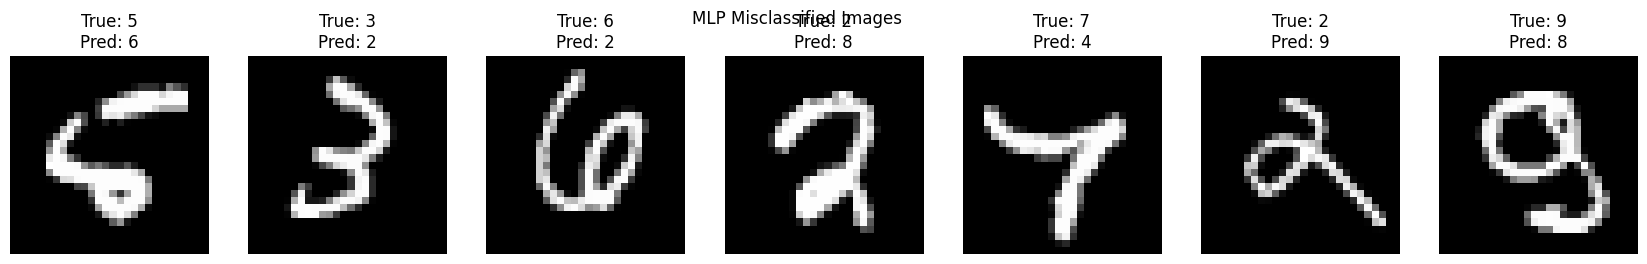


KAN Misclassified Images:


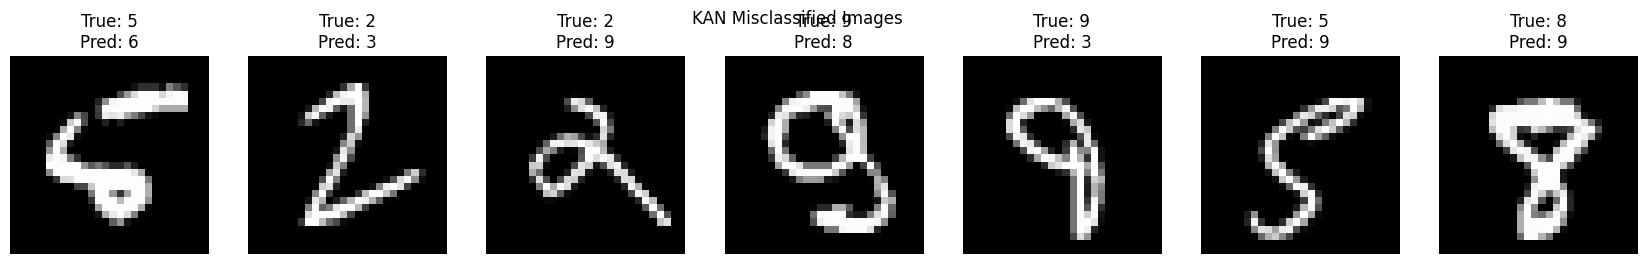

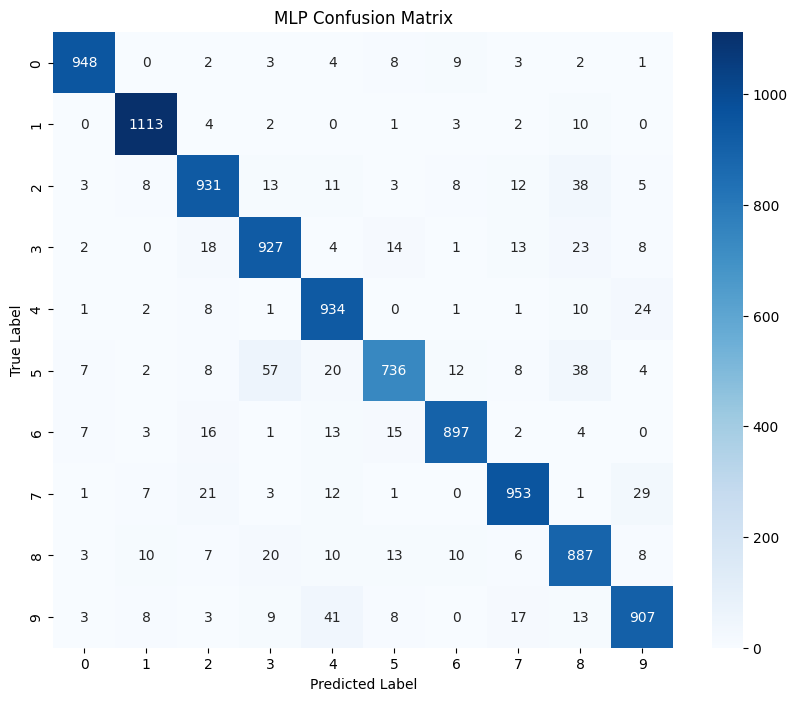

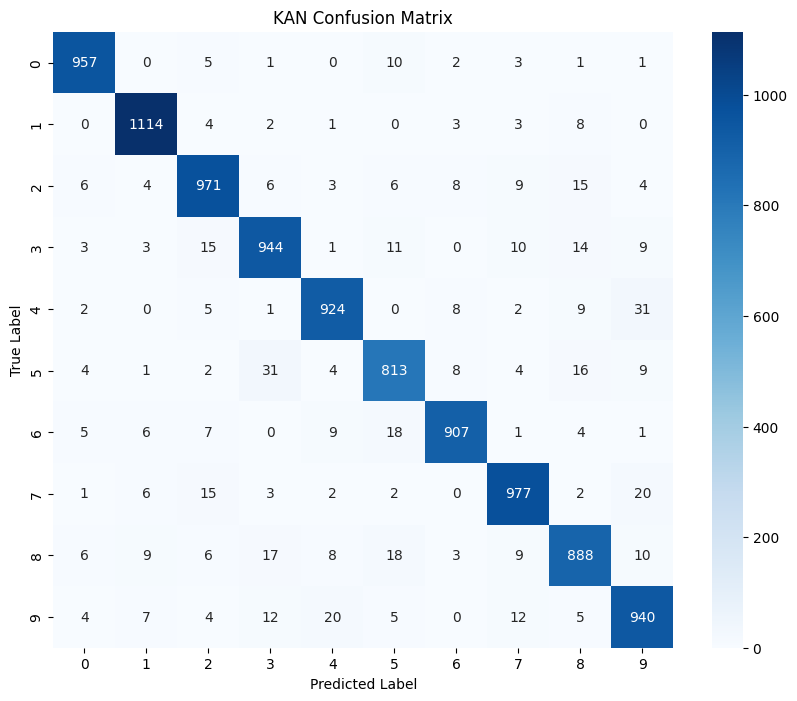

In [40]:
# Visualize MLP Misclassifications
print("\nMLP Misclassified Images:")
visualize_misclassifications(mlp_misclassified, num_images=7, title='MLP Misclassified Images')

# Visualize KAN Misclassifications
print("\nKAN Misclassified Images:")
visualize_misclassifications(kan_misclassified, num_images=7, title='KAN Misclassified Images')

# Plot confusion matrices
plot_confusion_matrix(mlp_model, test_loader, title='MLP Confusion Matrix')
plot_confusion_matrix(kan_model, test_loader, title='KAN Confusion Matrix')

